In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Plotting routines

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import gridspec

            
def plot_q_retrieval(flight,ar_of_day,var_to_retrieve,var_retrieved):
    correct_sector=True
    if flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            print("This AR sector suffers HAMP data gaps")
            correct_sector=False
        elif ar_of_day=="AR_entire_2":
            print("This sector overpasses sea-ice where the retrieval is not yet performing correctly.")
            correct_sector=False
    if correct_sector:
        set_font=18
        matplotlib.rcParams.update({"font.size":set_font})
        hours=mdates.MinuteLocator(byminute=[0,30],interval=1)
        h_fmt=mdates.DateFormatter("%H:%M")
        humidity_colormap="terrain_r"
        temperature_colormap="RdYlBu_r"
        if var_to_retrieve=="q" or var_to_retrieve=="log_q":
            cmap_to_use=humidity_colormap
            val_max=6
            val_min=0
            val_values=var_retrieved.T*1000
            unit_name="Specific humidity (g/kg)"
        elif var_to_retrieve=="t":
            cmap_to_use=temperature_colormap
            val_max=275
            val_min=210
            val_values=var_retrieved.T
            unit_name="Temperature (K)"
            levels=np.linspace(val_min,val_max,61)
        # Real figure
        fig=plt.figure(figsize=(12,9))
        ax1=fig.add_subplot(111)

        C1=ax1.pcolormesh(var_retrieved.index,var_retrieved.columns/1000,val_values,
                  vmin=val_min,vmax=val_max,cmap=cmap_to_use)
        #for sonde_release in sonde_data["IWV"].index:
        #    ax1.axvline(x=sonde_release,color="gray",ls="--",lw=3)

        cb=plt.colorbar(C1,extend="max")
        cb.set_label(unit_name)
        ax1.set_ylabel("Height (km)")
        ax1.set_xlabel("Time")
        ax1.set_ylim([0,15])
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_title("HAMP-TBs Retrieval "+var_to_retrieve)
        fig.savefig("HAMP_Retrieval_Tbs_"+var_to_retrieve+".png",dpi=300,bbox_inches="tight")
        print("Figure saved as:","HAMP_Retrieval_Tbs_"+var_to_retrieve+".png")
        plt.show()

def plot_vertical_sonde_profiles(Moisture_CONV,plot_path):
    matplotlib.rcParams.update({"font.size":16})
    sonde_fig=plt.figure(figsize=(12,12))
    ax1=sonde_fig.add_subplot(131)
    ax2=sonde_fig.add_subplot(132)
    ax3=sonde_fig.add_subplot(133,sharey=ax2)
    ax1.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["q"]*1000,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="lightblue",lw=1)
    mean_sector_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].mean(axis=1)
    ax1.plot(mean_sector_q*1000,mean_sector_q.index/1000,color="darkblue",lw=2)

    ax1.set_ylim([0,12])
    ax2.set_ylim([0,12])
    ax3.set_ylim([0,12])

    ax1.set_xlim([0,6])
    #wind speed
    ax2.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
         color="thistle",lw=1)
    mean_sector_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].mean(axis=1)
    ax2.plot(mean_sector_wind,mean_sector_wind.index/1000,color="purple",lw=2)
    ax2.set_xlim([0,50])
    #transport
    mean_sector_transport=Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"].mean(axis=1)
    ax3.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="darkseagreen")
    ax3.plot(mean_sector_transport,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  lw=2,color="darkgreen")
    ax3.set_xlim([0,0.15])
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax1.set_xlabel("Specific Humidity (g/kg)")
    ax2.set_xlabel("Wind speed (m/s)")
    ax3.set_xlabel("Moisture Transport (g/kgms)")

    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    ax3.yaxis.set_tick_params(width=2,length=6)
    ax3.xaxis.set_tick_params(width=2,length=6)
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
        ax2.spines[axis].set_linewidth(3)
        ax3.spines[axis].set_linewidth(3)
    ax1.set_ylabel("Height (km)")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.suptitle("Sonde Moisture transport convergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    
    sns.despine(offset=10,ax=ax1)
    sns.despine(offset=10,ax=ax2)
    sns.despine(offset=10,ax=ax3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Sondes.png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
#%% Plotting
def plot_haloac3_atmospheric_moist_trans_divergence(Moisture_CONV,ICON_Moisture_CONV,
        highres_ICON_Moisture_CONV,
        Retr_Moisture_CONV,ERA5_Moisture_CONV,sector_to_plot,
        z_height_icon,hr_z_height_icon,z_height_retrieval,z_height_era5=np.nan,
        plot_path=os.getcwd()+"/../plots/",plot_sondes=True,do_plot_icon=True,
        do_plot_era5=False,scalar_based_div=True,save_for_manuscript=True):
    """
    This routine creates the plot showing the profiles of sonde-based moisture transport divergence 
    (comprising moisture advection and mass divergence).
    """
    
    import matplotlib
    plot_retrieval=False
    
    import seaborn as sns
    matplotlib.rcParams.update({"font.size":24})
    divergence_plot=plt.figure(figsize=(16,9))
    ax1=divergence_plot.add_subplot(121)
    ax2=divergence_plot.add_subplot(122)
    # Mass divergence
    ax1.axvline(x=0,ls="--",lw=3,color="grey")
    ax2.axvline(x=0,ls="--",lw=3,color="grey")
    
    if plot_sondes:
        # Either sonde scalar based or vector based
        if scalar_based_div:
            if isinstance(Moisture_CONV.div_scalar_mass[sector_to_plot],pd.Series):
                ax1.plot(Moisture_CONV.div_scalar_mass[sector_to_plot].values,
                 Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
            else:
                ax1.plot(Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values,
                 Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
                ax1.fill_betweenx(Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                    x1=Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values-\
                    Moisture_CONV.div_scalar_mass[sector_to_plot]["unc"].values,
                    x2=Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values+\
                    Moisture_CONV.div_scalar_mass[sector_to_plot]["unc"].values,
                                color="lightgreen",alpha=0.4)
        else:
            if isinstance(Moisture_CONV.div_vector_mass[sector_to_plot],pd.Series):
                ax1.plot(Moisture_CONV.div_vector_mass[sector_to_plot].values,
                 Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=4,label="Dropsondes")
            else:
                ax1.plot(Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values,
                 Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=4,label="Dropsondes")
                ax1.fill_betweenx(Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                    x1=Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values-\
                    Moisture_CONV.div_vector_mass[sector_to_plot]["unc"].values,
                    x2=Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values+\
                    Moisture_CONV.div_vector_mass[sector_to_plot]["unc"].values,
                                color="lightgreen",alpha=0.4)
    if do_plot_icon:
        if scalar_based_div:
            ax1.plot(ICON_Moisture_CONV.div_scalar_mass[sector_to_plot].values,
             z_height_icon.values[1:]/1000,color="black",marker="s",
             markersize=2,lw=2,ls="--",label="ICON-2km (Sondes)")
        else:
            ax1.plot(ICON_Moisture_CONV.div_vector_mass[sector_to_plot].values,
             z_height_icon.values[1:]/1000,color="dimgrey",marker="s",
             markersize=2,lw=2,ls="--",label="ICON (Sondes)")
            ax1.plot(highres_ICON_Moisture_CONV.div_vector_mass[sector_to_plot].values,
             hr_z_height_icon.values[1:]/1000,color="black",marker="s",
             markersize=2,lw=3,ls="-",label="ICON (HALO Track)")
    if do_plot_era5:
        ax1.plot(ERA5_Moisture_CONV.div_vector_mass.values,
             z_height_era5.values/1000,color="orange",marker="s",
             markersize=2,lw=3,ls="-",label="ERA5 (HALO Track)")
    if plot_retrieval:
        ax1.plot(Retr_Moisture_CONV.div_scalar_mass[sector_to_plot].values,
             z_height_retrieval.values/1000,color="teal",lw=3,ls="-.",label="HAMP")

    ax1.set_xlim([-1.5e-4,1.5e-4])
    ax1.set_xticks([-1e-4,0,1e-4])
    ax1.set_xticklabels(["-1e-4","0","1e-4"])
    ax1.text(x=0.6,y=0.6,s="Vertical Integral\nBudget Contribution:",transform=ax1.transAxes,color="k",
            fontsize=20)
    ax1.text(x=0.04,y=0.95,s="(a)",transform=ax1.transAxes,color="k",fontsize=22)
    if plot_sondes:
        ax1.text(x=0.7,y=0.54,s=str(np.round(Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax1.transAxes,color="darkgreen",fontsize=20)
    if do_plot_icon:
        ax1.text(x=0.7,y=0.49,s=str(np.round(ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax1.transAxes,fontsize=20,color="dimgrey")
        ax1.text(x=0.7,y=0.44,s=str(np.round(highres_ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax1.transAxes,fontsize=20,color="k")
    if do_plot_era5:
        ax1.text(x=0.7,y=0.39,s=str(np.round(ERA5_Moisture_CONV.integrated_divergence["CONV"].values[0],2))+\
                 "$\mathrm{mm\,h}^{-1}$",transform=ax1.transAxes,fontsize=20,color="orange")
        #str(np.round(-1*ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
    if plot_retrieval:
        ax1.text(x=0.7,y=0.5,s=str(np.round(-1*Retr_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax1.transAxes,fontsize=16,color="teal")
    ax1.set_xlabel("Mass Divergence ($DIV_{\mathrm{mass}}$) in $\mathrm{g\,kg}^{-1}\,\mathrm{s}^{-1}$")
    ax1.set_ylabel("Height in km")
    ax1.set_ylim([0,10])
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax1.legend(loc="upper right",fontsize=16,bbox_to_anchor=[1.15,1.0])
    
    # moisture advection
    if plot_sondes:
        if scalar_based_div:
            if isinstance(Moisture_CONV.adv_q_calc[sector_to_plot],pd.Series):
                ax2.plot(Moisture_CONV.adv_q_calc[sector_to_plot].values,
                 Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=2)
            else:
                ax2.plot(Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values,
                 Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=4)
                ax2.fill_betweenx(y=Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 x1=Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values-\
                        Moisture_CONV.adv_q_calc[sector_to_plot]["unc"].values,
                 x2=Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values+\
                        Moisture_CONV.adv_q_calc[sector_to_plot]["unc"].values,
                 color="lightgreen",alpha=0.4)
        else:
            # vector based results
            if isinstance(Moisture_CONV.adv_q_vector[sector_to_plot],pd.Series):
                ax2.plot(Moisture_CONV.adv_q_vector[sector_to_plot].values,
                 Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=4)
            else:
                ax2.plot(Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values,
                 Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=4)
                ax2.fill_betweenx(y=Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 x1=Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values-\
                        Moisture_CONV.adv_q_vector[sector_to_plot]["unc"].values,
                 x2=Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values+\
                        Moisture_CONV.adv_q_vector[sector_to_plot]["unc"].values,
                 color="lightgreen",alpha=0.4)
            
    if do_plot_icon:
        if scalar_based_div:
            ax2.plot(ICON_Moisture_CONV.adv_q_calc[sector_to_plot].values,
             z_height_icon.values[1::]/1000,
             color="k",markersize=2,ls="--",lw=4)
        else:
            ax2.plot(ICON_Moisture_CONV.adv_q_vector[sector_to_plot].values,
             z_height_icon.values[1::]/1000,
             color="dimgrey",markersize=2,ls="--",lw=2)
            ax2.plot(highres_ICON_Moisture_CONV.adv_q_vector[sector_to_plot].values,
             z_height_icon.values[1::]/1000,
             color="k",markersize=2,ls="-",lw=3)
    if do_plot_era5:
        ax2.plot(ERA5_Moisture_CONV.adv_q_vector.values,
             z_height_era5.values/1000,
             color="orange",markersize=2,ls="-",lw=3)
            
    if plot_retrieval:
        ax2.plot(Retr_Moisture_CONV.adv_q_calc[sector_to_plot].values,
         z_height_retrieval.values/1000,
         color="teal",markersize=2,ls="-.",lw=3)
    ax2.text(x=0.04,y=0.95,s="(b)",transform=ax2.transAxes,color="k",fontsize=22)    
    ax2.set_ylim([0,10])
    ax2.set_xlim([-1.5e-4,1.5e-4])
    ax2.set_xticks([-1e-4,0,1e-4])
    ax2.set_xticklabels(["-1e-4","0","1e-4"])
    ax2.set_xlabel("Advection ($-ADV_{\mathrm{q}}$) in $\mathrm{g\,kg}^{-1}\,\mathrm{s}^{-1}$")
    for axis in ['bottom','left']:
        ax2.spines[axis].set_linewidth(3)
    ax2.set_yticklabels("")
    if plot_sondes:
        ax2.text(x=0.7,y=0.54,s=str(np.round(Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax2.transAxes,color="darkgreen",fontsize=20)
    if do_plot_icon:
        ax2.text(x=0.7,y=0.49,s=str(np.round(ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax2.transAxes,color="dimgrey",fontsize=20)
        ax2.text(x=0.7,y=0.44,s=str(np.round(ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax2.transAxes,color="k",fontsize=20)
    if do_plot_era5:
        ax2.text(x=0.7,y=0.39,s=str(np.round(ERA5_Moisture_CONV.integrated_divergence["ADV"].values[0],2))+\
                 "$\mathrm{mm\,h}^{-1}$",transform=ax2.transAxes,color="orange",fontsize=20)
        #isture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         
    if plot_retrieval:
        ax2.text(x=0.7,y=0.41,s=str(np.round(-1*Retr_Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mm\,h}^{-1}$",transform=ax2.transAxes,color="teal",fontsize=20)
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    #plt.suptitle("Sonde Moisture transport divergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    sns.despine(offset=10)
    plt.subplots_adjust(wspace=0.3)
    
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_moist_transp_divergence"
    if not do_plot_icon:
        fig_name+="_no_ICON"
    
    if save_for_manuscript:
        if not do_plot_icon:
            fig_name="Fig06_"+fig_name
        else:
            fig_name="Fig14_"+fig_name
        
    file_end=".pdf"
    fig_name+=file_end
    divergence_plot.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
def plot_internal_iwv_tendency(sonde_times_series,Dropsondes,IWV_retrieved,sector_to_plot="warm"):
    # ---- Add this one : internal_sondes_dict["cold"]
    matplotlib.rcParams.update({"font.size":28})
    # Internal sondes iwv
    time_list=[str(time) for time in sonde_times_series.index]
    Dropsondes["new_alt"]=Dropsondes["alt"].copy()
    new_key_list=[]
    for key in [*Dropsondes["alt"].keys()]:
        new_key=str(pd.Timestamp(key))
        Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)
    iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
    minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
    iwv_sonde_diff=iwv_sonde.diff()[-1]/minutes_to_divide*60

    #hamp_gradients using 1min mean
    hamp_iwv_internal_mean=pd.Series(data=np.nan,index=iwv_sonde.index)
    for t,sonde_time in enumerate(iwv_sonde.index):
        if flight[0]=="RF06" and ar_of_day=="AR_entire_1" and t==0:
            sonde_period_start= pd.Timestamp("2022-03-16 12:01")-pd.Timedelta("30s")
            sonde_period_end  = pd.Timestamp("2022-03-16 12:01")+pd.Timedelta("30s")
        else:    
            sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta("30s")
            sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta("30s")
    
        mean_iwv_sonde_values=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)].mean()
        hamp_iwv_internal_mean.loc[sonde_time]=mean_iwv_sonde_values

    hamp_iwv_diff=hamp_iwv_internal_mean.diff()/minutes_to_divide*60
    icon_iwv_diff=pd.Series(data=np.nan, index=iwv_sonde.index)

    iwv_sonde_fig=plt.figure(figsize=(8,14))
    ax1=iwv_sonde_fig.add_subplot(111)
    matplotlib.rcParams['axes.linewidth'] = 3
    ax1.patch.set_facecolor('lightgrey')
    ax1.patch.set_alpha(0.5)
    time_key_list=[*Dropsondes["q"].keys()]
    if sector_to_plot=="warm":
        colors=["darkorange","moccasin"]
    else:
        colors=["darkviolet","plum"]

    for c,sonde_time in enumerate(internal_sondes_dict[sector_to_plot]):
        if sector_to_plot=="warm":
            relevant_timestamp=time_key_list[sonde_time]
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
            color="k",s=140)
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
                label="Sonde "+str(relevant_timestamp),color=colors[c],s=80)
            iwv_sonde=Dropsondes["q"][relevant_timestamp]
        else:
            relevant_timestamp=pd.Timestamp(sonde_time)
        
        icon_q_sondes={}
        icon_z_sondes={}
        if relevant_timestamp>halo_df.index[-1]:
            icon_q_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=snd_halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        else:
            icon_q_sondes["Sonde"+str(c)]=halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        ax1.scatter(icon_q_sondes["Sonde"+str(c)]*1000,
                icon_z_sondes["Sonde"+str(c)]/1000,
                marker="v", s=150, color=colors[c],edgecolor="k",
                label="ICON "+str(relevant_timestamp))
    if sector_to_plot=="warm":
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    else:
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    ax1.set_xlabel("Specific humidity (${\mathrm{gkg}}^{-1}$)")
    ax1.set_ylabel("Height (km)")
    ax1.set_xlim([0,5])
    ax1.set_ylim([0,12])
    if sector_to_plot=="warm":
        ax1.text(1.4,7,"$\dfrac{\delta {IWV}_{\mathrm{Sonde}}}{\delta t}=$"+str(round(iwv_sonde_diff,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,6,"$\dfrac{\delta {IWV}_{\mathrm{ICON}}}{\delta t}=$"+str(round(iwv_icon_diff_h,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,5,"$\dfrac{\delta {IWV}_{\mathrm{HAMP}}}{\delta t}=$"+str(round(hamp_iwv_diff[-1],2))+" $\mathrm{mmh}^{-1}$",
        fontsize=25)
    ax1.xaxis.set_tick_params(width=3,length=10)
    ax1.yaxis.set_tick_params(width=3,length=10)
    ax1.legend(fontsize=24)
    sns.despine(offset=10)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_iwv_tendency.png"
    iwv_sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

## Switches and Definitions

In [3]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
calibrated_hamp=True
flight=["RF05"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
include_hamp_retrieval=False
do_plotting=True

plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


In [4]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)

In [5]:
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))

## Reanalysis (ERA-5)

In [6]:
import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds        

In [7]:
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])

relevant_sondes_dict={}
internal_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
        
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_warm_internal_sondes=[7,13]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            #relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                                     index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
            relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
            internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_warm_internal_sondes=[13,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
    elif flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[21,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]

### ICON

In [8]:
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
icon_resolution=2000 # units m
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)
halo_df=halo_df.rename(columns={"lat":"latitude",
                                "lon":"longitude"})

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                            cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                            interpolated_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv",
                            interpolated_hmc_file=None,ar_of_day=ar_of_day,
                            synthetic_icon=False,
                            synthetic_flight=False)
if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
    ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    
# ICON Values on HALO
halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()        
#Second ar of day
snd_ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                interpolated_hmp_file=flight[0]+"_"+"AR_entire_2"+"_"+"interpolated_HMP.csv",
                interpolated_hmc_file=None,ar_of_day="AR_entire_2",
                synthetic_icon=False,synthetic_flight=False)
if campaign=="HALO_AC3":
    snd_ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    # ICON Values on HALO
    snd_halo_icon_hmc=snd_ICON_on_HALO.load_hwc(with_hydrometeors=False)
    snd_halo_icon_hmp=snd_ICON_on_HALO.load_interpolated_hmp()


File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF05/RF05_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened
File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF05/RF05_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


In [9]:
do_plotting=False # but plot is needed for HALO-(AC)3 paper and Essay
if do_plotting:
    import plotting_sector_sonde_locations as sonde_plotting
    sonde_plotting.main(flight,ar_of_day,ds,halo_df,Dropsondes,relevant_sondes_dict,
         internal_sondes_dict,snd_halo_icon_hmp,plot_path,add_other_sectors=False)

In [10]:
relevant_sector_sondes={}
relevant_sector_sondes["warm"]=relevant_warm_sector_sondes
relevant_sector_sondes["cold"]=relevant_cold_sector_sondes

## --> add relevant sondes with "cold" and "warm" key.    
inflow=False
# Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")
cmpgn_cls=flightcampaign.HALO_AC3(is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=flight,instruments=["radar","radiometer","sonde"])               
# HALO Dropsondes
Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,
                 grid_name="Real_Sondes",sector_types=[sector_to_plot],
                do_instantan=False,calc_from_scalar_values=scalar_based_div)
print("HALO moisture convergence class allocated")
# ERA5
ERA5_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,grid_name="ERA5",
                                      sector_types=[sector_to_plot],do_instantan=False,calc_from_scalar_values=scalar_based_div)
print("ERA5 moisture convergence class allocated")
# ICON
ICON_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,
                 grid_name="ICON_Sondes",sector_types=[sector_to_plot],do_instantan=False)
print("ICON moisture convergence class allocated")

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3
HALO moisture convergence class allocated
ERA5 moisture convergence class allocated
ICON moisture convergence class allocated


### Highres full cross-section consideration (Continuous track)

In [11]:
highres_ICON_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,
                 grid_name="ICON_Cross_section",sector_types=[sector_to_plot],do_instantan=False)
AR_sector_in   = AR_inflow["entire_inflow"].loc[\
                    relevant_sondes_dict["warm_sector"]["in"].index[0]:\
                    relevant_sondes_dict["warm_sector"]["in"].index[-1]]

AR_sector_out  = AR_outflow["entire_outflow"].loc[\
                    relevant_sondes_dict["warm_sector"]["out"].index[0]:\
                    relevant_sondes_dict["warm_sector"]["out"].index[-1]]

in_outflow_merge=pd.concat([AR_sector_in,AR_sector_out])
in_outflow_index=in_outflow_merge.index

In [12]:
# Divergence values result from vector based calculations of wind field, not scalar wspeed
Moisture_CONV.perform_entire_sonde_ac3_divergence_vector_calcs(Dropsondes,relevant_sector_sondes,with_uncertainty=True)
Moisture_CONV.new_vertically_integrated_divergence()

['2022-03-15T10:19:22.000000000', '2022-03-15T10:28:33.000000000', '2022-03-15T10:34:37.000000000', '2022-03-15T10:41:45.000000000', '2022-03-15T10:49:06.000000000', '2022-03-15T10:55:47.000000000', '2022-03-15T11:03:29.000000000', '2022-03-15T11:52:30.000000000', '2022-03-15T12:05:05.000000000', '2022-03-15T12:28:34.000000000', '2022-03-15T12:36:29.000000000', '2022-03-15T12:40:08.000000000', '2022-03-15T12:43:47.000000000', '2022-03-15T14:00:48.000000000', '2022-03-15T14:11:44.000000000', '2022-03-15T14:34:01.000000000', '2022-03-15T14:40:56.000000000', '2022-03-15T14:47:58.000000000', '2022-03-15T14:54:30.000000000', '2022-03-15T15:01:07.000000000', '2022-03-15T15:05:56.000000000', '2022-03-15T15:13:18.000000000', '2022-03-15T16:09:45.000000000', '2022-03-15T16:22:53.000000000', '2022-03-15T16:44:06.000000000']
domain ready for regression
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Perform divergence via regression 

In [13]:
Moisture_CONV.integrated_divergence

{'warm': {'mass_div': -0.5396710780836217, 'q_ADV': -0.55394495354216}}

In [14]:
if sector_to_plot=="warm": relevant_sondes=relevant_sector_sondes["warm"]
else: relevant_sondes=relevant_sector_sondes["cold"]
sonde_sector_times=sonde_times_series.iloc[relevant_sondes].index
if flight[0]=="RF05" and sector_to_plot=="cold":
    sonde_sector_times=sonde_sector_times.append(relevant_sondes_dict["cold_sector"]["out"].index)

## ERA5

In [15]:
# LOAD collocated ERA-5 HMC
#import gridonhalo
era5_hmc=ERA5_on_HALO.load_hwc()
HMC=era5_hmc.copy()

Hydrometeor Content Profiles are already interpolated and saved
So load the data
IWC
LWC
PWC
Geopot_Z
q
theta_e
u
v


## Instantaneous ERA5 data

In [16]:
paths_dict={}
paths_dict["current_path"]          = os.getcwd()
paths_dict["major_path"]            = os.path.abspath("../../../")
paths_dict["base_working_path"]     = paths_dict["major_path"]+ \
                                        "/my_GIT/Synthetic_Airborne_Arctic_ARs/"
paths_dict["aircraft_base_path"]    = paths_dict["major_path"]+\
                                            "/Work/GIT_Repository/"
paths_dict["config_path"]           = paths_dict["base_working_path"]+\
                                            "/config/"
paths_dict["working_path"]          = paths_dict["base_working_path"]+\
                                            "/src/"
paths_dict["script_path"]           = paths_dict["base_working_path"]+\
                                            "/scripts/"
paths_dict["major_script_path"]     = paths_dict["base_working_path"]+\
                                            "/major_scripts/"
sys.path.insert(1, os.path.join(sys.path[0], paths_dict["working_path"]))
sys.path.insert(3, os.path.join(sys.path[0], paths_dict["script_path"]))
sys.path.insert(4, os.path.join(sys.path[0], paths_dict["major_script_path"]))

### from ERA5_Moisture_CONV.calc_moist*

In [17]:
#budget_data_path=cmpgn_cls.campaign_data_path+"budget/"
analysed_flight=flight[0]#"RF05"        
#ar_of_day=#"AR_entire_1"
grid_name="ERA5"
sector="warm_sector"
number_of_sondes=100
#-----------------------------------------------------#
# Sonde number
sondes_selection={}
sondes_selection["inflow_"+sector]=np.linspace(
        0,AR_sector_in.shape[0]-1,
        num=number_of_sondes).astype(int)
sondes_selection["outflow_"+sector]=np.linspace(
        0,AR_sector_out.shape[0]-1,
        num=number_of_sondes).astype(int)

inflow_sondes_times=\
        AR_sector_in.index[\
            sondes_selection["inflow_"+sector]]
outflow_sondes_times=\
        AR_sector_out.index[\
                sondes_selection["outflow_"+sector]]
sondes_pos_inflow=AR_sector_in[["Halo_Lat","Halo_Lon"]].loc[inflow_sondes_times]
sondes_pos_outflow=AR_sector_out[["Halo_Lat","Halo_Lon"]].loc[outflow_sondes_times]
sondes_pos_all=pd.concat([sondes_pos_inflow,sondes_pos_outflow])
#sondes_selection

In [18]:
# Select sonde values of vertical quantities
if not "q" in HMC.keys():
    HMC["q"]=HMC["specific_humidity"].copy()
inflow_times  =   inflow_sondes_times
outflow_times =   outflow_sondes_times
q_inflow_sondes =HMC["q"].loc[inflow_times]
q_outflow_sondes=HMC["q"].loc[outflow_times]
u_inflow_sondes =HMC["u"].loc[inflow_times]
u_outflow_sondes=HMC["u"].loc[outflow_times]
v_inflow_sondes =HMC["v"].loc[inflow_times]
v_outflow_sondes=HMC["v"].loc[outflow_times]
z_inflow_sondes =HMC["Geopot_Z"].loc[inflow_times]
z_outflow_sondes=HMC["Geopot_Z"].loc[outflow_times]
# calculate additional parameters
wind_inflow_sondes=np.sqrt(u_inflow_sondes**2+\
                   v_inflow_sondes**2)
wind_outflow_sondes=np.sqrt(u_outflow_sondes**2+\
                    v_outflow_sondes**2)
moist_transport_inflow=q_inflow_sondes*wind_inflow_sondes
moist_transport_outflow=q_outflow_sondes*wind_outflow_sondes

### Prepare the pattern for regression method
sondes_pos_all=ERA5_Moisture_CONV.get_xy_coords_for_domain(
                        sondes_pos_all)
#z_inflow_sondes

domain ready for regression


In [19]:
#######################################################
#-----------------------------------------------------#
domain_values={}
moist_transport_inflow=moist_transport_inflow.groupby(level=0).last()
moist_transport_outflow=moist_transport_outflow.groupby(level=0).last()
u_inflow_sondes=u_inflow_sondes.groupby(level=0).last()
u_outflow_sondes=u_outflow_sondes.groupby(level=0).last()
v_inflow_sondes=v_inflow_sondes.groupby(level=0).last()
v_outflow_sondes=v_outflow_sondes.groupby(level=0).last()
q_inflow_sondes=q_inflow_sondes.groupby(level=0).last()
q_outflow_sondes=q_outflow_sondes.groupby(level=0).last()
wind_inflow_sondes=wind_inflow_sondes.groupby(level=0).last()
wind_outflow_sondes=wind_outflow_sondes.groupby(level=0).last()
z_inflow_sondes=z_inflow_sondes.groupby(level=0).last()
z_outflow_sondes=z_outflow_sondes.groupby(level=0).last()

domain_values["transport"]=pd.concat([moist_transport_inflow,
                                      moist_transport_outflow])
domain_values["u"]=pd.concat([u_inflow_sondes,
                                  u_outflow_sondes])
domain_values["v"]=pd.concat([v_inflow_sondes,
                                  v_outflow_sondes])
domain_values["q"]=pd.concat([q_inflow_sondes,
                                  q_outflow_sondes])
domain_values["wind"]=pd.concat([wind_inflow_sondes,
                              wind_outflow_sondes])
domain_values["z"]=pd.concat([z_inflow_sondes,
                                  z_outflow_sondes])


#mean_qv,dx_qv,dy_qv=ERA5_Moisture_CONV.run_regression(sondes_pos_all,
#                                domain_values,"transport")

mean_q,dx_q_calc,dy_q_calc=ERA5_Moisture_CONV.run_regression(sondes_pos_all,
                                       domain_values,"q")
mean_u,dx_u,dy_u=ERA5_Moisture_CONV.run_regression(sondes_pos_all,
                                 domain_values,"u")
mean_v,dx_v,dy_v=ERA5_Moisture_CONV.run_regression(sondes_pos_all,
                                 domain_values,"v")

div_mass=domain_values["q"].mean(axis=0).values*1000*\
        (dx_u+dy_v)
adv_q=(domain_values["u"].mean(axis=0).values*dx_q_calc+\
           domain_values["v"].mean(axis=0).values*dy_q_calc)*\
            1000

ERA5_budget_regression_profile_df=pd.DataFrame(data=np.nan,
                index=div_mass.index,
                columns=["CONV","ADV_calc"])
ERA5_budget_regression_profile_df["CONV"]=div_mass.values
ERA5_budget_regression_profile_df["ADV_calc"]=adv_q.values
z_height_era5=domain_values["z"].mean(axis=0)
ERA5_budget_regression_profile_df["z"]=z_height_era5.values
ERA5_Moisture_CONV.div_vector_mass=div_mass.copy()
ERA5_Moisture_CONV.adv_q_vector=adv_q.copy()
save_budgets=True
budget_data_path=ERA5_Moisture_CONV.cmpgn_cls.campaign_data_path+"/data/budgets/"
# Save budget values
if save_budgets:
    name_arg=""
    file_end=".csv"
    #if use_flight_sonde_locations:
    #    name_arg="_on_flight"+name_arg
    budget_file_name=flight[0]+"_AR_"+sector+"_"+\
            grid_name+"_regr_sonde_no_"+str(number_of_sondes)+\
                name_arg+"_vectorised"
    budget_file_name+=file_end
    ERA5_budget_regression_profile_df.to_csv(
    path_or_buf=budget_data_path+budget_file_name)    
    print("Convergence components saved as: ",budget_data_path+budget_file_name)
    sonde_pos_fname=flight[0]+"_Sonde_Location_"+sector+"_"+\
                grid_name+"_regr_sonde_no_"+str(number_of_sondes)
    sonde_pos_fname=sonde_pos_fname+".csv"
    sondes_pos_all.to_csv(path_or_buf=budget_data_path+\
                         sonde_pos_fname)
    print("Sonde position saved as:",budget_data_path+sonde_pos_fname)
ERA5_budget_regression_profile_df # g/kg s

Convergence components saved as:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF05_AR_warm_sector_ERA5_regr_sonde_no_100_vectorised.csv
Sonde position saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF05_Sonde_Location_warm_sector_ERA5_regr_sonde_no_100.csv


,CONV,ADV_calc,z
150.0,1.700169e-07,1.409184e-07,13244.737341
175.0,2.542834e-07,2.325833e-07,12298.616228
200.0,-2.097912e-07,-2.992771e-07,11487.886500
225.0,1.309161e-07,1.171267e-07,10763.265446
250.0,1.414433e-06,1.066735e-06,10099.140812
300.0,1.625209e-06,6.072333e-06,8910.432546
350.0,2.167858e-07,1.519124e-05,7866.093742
400.0,-3.973064e-07,2.997512e-05,6931.595706
450.0,1.089125e-05,4.033536e-05,6087.306126
500.0,1.798733e-06,5.261774e-05,5316.546328


#### Vertically integrated components

In [20]:
#ERA5_budget_regression_profile_df

In [21]:
pres_index=pd.Series(ERA5_budget_regression_profile_df.index*100)
g=9.82
warm_budgets={}
warm_budgets["ADV"]  = pd.Series()
warm_budgets["CONV"] = pd.Series()
campaign_id="AC3_"
for term in ["ADV","CONV"]:
    if term=="ADV":
        series_term=term+"_calc"
    else:
        series_term=term
    # From g/kg*s to mm/h
    warm_budgets[term].at[campaign_id+flight[0]+"_sonde_100_"+term]=\
                    -1/(g*997)*np.trapz(ERA5_budget_regression_profile_df[series_term]/1000, # to kg/kg
                                 axis=0,x=pres_index)*3600*1000 # from m to mm

ERA5_Moisture_CONV.integrated_divergence=warm_budgets # mm/h
ERA5_Moisture_CONV.integrated_divergence

{'ADV': AC3_RF05_sonde_100_ADV   -0.502094
 dtype: float64,
 'CONV': AC3_RF05_sonde_100_CONV   -0.540925
 dtype: float64}

In [22]:
# {'ADV': AC3_RF06_sonde_100_ADV    0.564908# 'CONV': AC3_RF06_sonde_100_CONV   -0.014369

In [23]:
Moisture_CONV.integrated_divergence

{'warm': {'mass_div': -0.5396710780836217, 'q_ADV': -0.55394495354216}}

### ICON Sonde values

In [24]:
# Allocate sonde values in sonde_icon_hmc
sonde_icon_hmc={}
for key in halo_icon_hmc.keys():
    sonde_icon_hmc[key]=halo_icon_hmc[key].loc[sonde_sector_times]       
sonde_icon_hmc["wind"]=np.sqrt(sonde_icon_hmc["u"]**2+sonde_icon_hmc["v"]**2)
sonde_icon_hmc["transport"]=sonde_icon_hmc["wind"]*sonde_icon_hmc["q"]
# Allocate Sondes Position all for ICON Moisture CONV, no rerun is needed
ICON_Moisture_CONV.sondes_pos_all=Moisture_CONV.sondes_pos_all.copy()

In [25]:
# High res ICON Sondes
highres_icon_hmc={}
for key in halo_icon_hmc.keys():
    highres_icon_hmc[key]=halo_icon_hmc[key].loc[in_outflow_index]       
highres_icon_hmc["wind"]=np.sqrt(highres_icon_hmc["u"]**2+\
                                 highres_icon_hmc["v"]**2)
highres_icon_hmc["transport"]=highres_icon_hmc["wind"]*highres_icon_hmc["q"]

# Allocate Sondes Position all for ICON Moisture CONV, no rerun is needed
highres_sondes_pos_all=pd.DataFrame(data=np.nan,columns=["Halo_Lat","Halo_Lon"],
                            index=pd.DatetimeIndex(in_outflow_index))
highres_sondes_pos_all["Halo_Lat"][:]=halo_df["latitude"].loc[in_outflow_index]
highres_sondes_pos_all["Halo_Lon"][:]=halo_df["longitude"].loc[in_outflow_index]

highres_ICON_Moisture_CONV.sondes_pos_all={}
#highres_sondes_pos_all_dict[sector_to_plot]=highres_sondes_pos_all
highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot]=highres_ICON_Moisture_CONV.get_xy_coords_for_domain(
                highres_sondes_pos_all)     

domain ready for regression


In [26]:
#####--Add new synthetic sonde releases in cold sector, where actual sondes are missing-----------------------------####
if flight[0]=="RF05" and sector_to_plot=="cold":
    ICON_Moisture_CONV.add_synthetic_sondes(sector_to_plot=sector,additional_sondes=pd.DataFrame())
else:
    print("All sondes available")

All sondes available


In [27]:
#sonde_icon_hmc[p] in Pa
#sonde_icon_hmc[q] in kg/kg

### ICON SONDES

In [28]:
# Regression Calculations 
sector_div_vars={}
uninterp_vars={}
interp_vars={}
# Run divergence calculations via regression for transport, q and wind

sector_icon_mean_qv,sector_icon_dx_qv,sector_icon_dy_qv=\
        ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_icon_hmc,"transport")

sector_icon_mean_q,sector_icon_dx_q_calc,sector_icon_dy_q_calc=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_icon_hmc,"q")

sector_icon_mean_scalar_wind,sector_icon_dx_scalar_wind,sector_icon_dy_scalar_wind=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                sonde_icon_hmc,
                                                "wind")
sector_icon_div_scalar_wind = (sector_icon_dx_scalar_wind+\
                                      sector_icon_dy_scalar_wind)
if not scalar_based_div:
    sector_icon_mean_u,sector_icon_dx_u,sector_icon_dy_u=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                sonde_icon_hmc,
                                                "u")
    sector_icon_mean_v,sector_icon_dx_v,sector_icon_dy_v=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                sonde_icon_hmc,
                                                "v")

In [29]:
###### Combine coefficients for advection and divergence
# combine specific humidity
if isinstance(sector_icon_dx_q_calc,pd.Series):
    sector_icon_div_q       = (sector_icon_dx_q_calc+\
                            sector_icon_dy_q_calc) #kg/kg
elif isinstance(sector_icon_dx_q_calc,pd.DataFrame):
    sector_icon_div_q       = pd.DataFrame()
    sector_icon_div_q["val"]= sector_icon_dx_q_calc[0]+sector_icon_dy_q_calc[0]
    sector_icon_div_q["unc"]= np.sqrt(sector_icon_dx_q_calc["unc"]**2+\
                                   sector_icon_dy_q_calc["unc"]**2) 
else:
    raise Exception("Something went completely wrong in the regression")

#-----------------------------------------------------------------#
# Intersection checks for products needed
#=sector_icon_div_qv.index.intersection(
#                        sector_icon_div_scalar_wind.index)
#intersect_index=intersect_index.intersection(
#                           sector_icon_div_q_calc.index)

### Both Divergence terms

In [30]:
# Mass Divergence (q * nabla_v)
if isinstance(sector_icon_dy_v,pd.Series):
    sector_icon_div_vector_mass=(sector_icon_dx_u+\
      sector_icon_dy_v)*\
         sonde_icon_hmc["q"].mean(axis=0)[1:].values*1000 #from kg/kg to g/kg
elif isinstance(sector_icon_dy_v,pd.DataFrame):
    sector_icon_div_vector_mass=pd.DataFrame()
    sector_icon_div_vector_mass["val"]=\
     (sector_icon_dx_u[0].loc[intersect_index]+\
      sector_icon_dy_v[0].loc[intersect_index])*\
         sonde_icon_hmc["q"].loc[\
                intersect_index].mean(axis=1).values*1000 #from kg/kg to g/kg
    sector_icon_div_vector_mass["unc"]=\
        np.sqrt(sector_icon_dx_u["unc"].loc[intersect_index]**2+\
            sector_icon_dy_v["unc"].loc[intersect_index]**2)*\
            sonde_icon_hmc[sector]["q"].loc[\
                intersect_index].mean(axis=1).values*1000

In [31]:
#Moisture Advection (v* nabla_q)
if isinstance(sector_icon_dx_q_calc,pd.DataFrame):
    sector_icon_adv_q_vector=pd.DataFrame()
    sector_icon_adv_q_vector["val"]=\
        (sector_icon_mean_u.loc[intersect_index]*\
         sector_icon_dx_q_calc[0].loc[intersect_index]+
         sector_icon_mean_v.loc[intersect_index]*\
         sector_dy_q_calc[0].loc[intersect_index])*1000 # from kg/kg to g/kg

    sector_icon_adv_q_vector["unc"]=\
        (sector_dx_q_vector["unc"].loc[intersect_index]*\
         sector_mean_u.loc[intersect_index]+\
         sector_dy_q_vector["unc"].loc[intersect_index]*\
         sector_mean_v.loc[intersect_index])*1000
else:
    sector_icon_adv_q_vector=(sector_icon_mean_u*\
         sector_icon_dx_q_calc+
         sector_icon_mean_v*\
         sector_icon_dy_q_calc)*1000


In [32]:
# Post calculations
# unified vertical grid
z_height=sonde_icon_hmc["Z_Height"].iloc[:,:].mean(axis=0)

# Assign to class
sector_icon_adv_q_vector.index    = z_height[1:]
sector_icon_div_vector_mass.index = z_height[1:]
ICON_Moisture_CONV.adv_q_vector={}
ICON_Moisture_CONV.adv_q_vector[sector_to_plot]          = sector_icon_adv_q_vector # (g/kg/s)
ICON_Moisture_CONV.div_vector_mass={}
ICON_Moisture_CONV.div_vector_mass[sector_to_plot] = sector_icon_div_vector_mass    # (g/kg/s)

#### ICON_Moisture_CONV vertically_integrated_divergence

In [33]:
integrated_divergence={}
p_grid=sonde_icon_hmc["p"].mean(axis=0)
pres_index=pd.Series(data=p_grid.values,index=z_height.values) # Pa
g=9.82

ICON_Moisture_CONV.div_vector_mass[sector_to_plot].index   = pres_index.dropna()
ICON_Moisture_CONV.adv_q_vector[sector_to_plot].index      = pres_index.dropna()

integrated_divergence[sector_to_plot]={}
integrated_divergence[sector_to_plot]["mass_div"]= -1/(g*997)*np.trapz(
ICON_Moisture_CONV.div_vector_mass[sector_to_plot].values/1000,
    axis=0,x=ICON_Moisture_CONV.div_vector_mass[sector_to_plot].index)*3600*1000
integrated_divergence[sector_to_plot]["q_ADV"]= -1/(g*997)*np.trapz(
    ICON_Moisture_CONV.adv_q_vector[sector_to_plot].values/1000,axis=0,
    x=ICON_Moisture_CONV.adv_q_vector[sector_to_plot].index)*3600*1000

ICON_Moisture_CONV.integrated_divergence=integrated_divergence

ICON_Moisture_CONV.integrated_divergence

{'warm': {'mass_div': -0.6240264751756235, 'q_ADV': -0.3004600499337994}}

### ICON Continuous HALO Track

In [34]:
# Regression Calculations 
hr_sector_div_vars={} # high-res
hr_uninterp_vars={}
hr_interp_vars={}
# Run divergence calculations via regression for transport, q and wind

hr_sector_icon_mean_qv,hr_sector_icon_dx_qv,hr_sector_icon_dy_qv=\
        highres_ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
            highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            highres_icon_hmc,"transport")

hr_sector_icon_mean_q,hr_sector_icon_dx_q_calc,hr_sector_icon_dy_q_calc=\
    highres_ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
        highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
            highres_icon_hmc,"q")

hr_sector_icon_mean_scalar_wind,hr_sector_icon_dx_scalar_wind,hr_sector_icon_dy_scalar_wind=\
    highres_ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
        highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
            highres_icon_hmc,"wind")

hr_sector_icon_div_scalar_wind = (hr_sector_icon_dx_scalar_wind+\
                                    hr_sector_icon_dy_scalar_wind)
if not scalar_based_div:
    hr_sector_icon_mean_u,hr_sector_icon_dx_u,sector_icon_dy_u=\
    highres_ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
        highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
            highres_icon_hmc,"u")
    hr_sector_icon_mean_v,hr_sector_icon_dx_v,hr_sector_icon_dy_v=\
    highres_ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
        highres_ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],highres_icon_hmc,"v")

In [35]:
###### Combine coefficients for advection and divergence
# combine specific humidity
if isinstance(hr_sector_icon_dx_q_calc,pd.Series):
    hr_sector_icon_div_q       = (hr_sector_icon_dx_q_calc+\
                            hr_sector_icon_dy_q_calc)*1000
elif isinstance(hr_sector_icon_dx_q_calc,pd.DataFrame):
    hr_sector_icon_div_q       = pd.DataFrame()
    hr_sector_icon_div_q["val"]= hr_sector_icon_dx_q_calc[0]+hr_sector_icon_dy_q_calc[0]
    hr_sector_icon_div_q["unc"]= np.sqrt(hr_sector_icon_dx_q_calc["unc"]**2+\
                                   hr_sector_icon_dy_q_calc["unc"]**2) 
else:
    raise Exception("Something went completely wrong in the regression")

#-----------------------------------------------------------------#
# Intersection checks for products needed
#intersect_index=sector_icon_div_qv.index.intersection(
#                        sector_icon_div_scalar_wind.index)
#intersect_index=intersect_index.intersection(
#                           sector_icon_div_q_calc.index)

In [36]:
# Both Divergence terms
# Mass Divergence (q * nabla_v)
if isinstance(sector_icon_dy_v,pd.Series):
    hr_sector_icon_div_vector_mass=(hr_sector_icon_dx_u+\
      hr_sector_icon_dy_v)*\
         highres_icon_hmc["q"].mean(axis=0)[1:].values*1000 #for g/kg from kg/kg
elif isinstance(hr_sector_icon_dy_v,pd.DataFrame):
    hr_sector_icon_div_vector_mass=pd.DataFrame()
    hr_sector_icon_div_vector_mass["val"]=\
     (hr_sector_icon_dx_u[0].loc[intersect_index]+\
      hr_sector_icon_dy_v[0].loc[intersect_index])*\
         highres_icon_hmc["q"].loc[\
                intersect_index].mean(axis=1).values*1000 #for g/kg from kg/kg
    hr_sector_icon_div_vector_mass["unc"]=\
        np.sqrt(hr_icon_dx_u["unc"].loc[intersect_index]**2+\
            hr_icon_dy_v["unc"].loc[intersect_index]**2)*\
            hr_icon_hmc[sector]["q"].loc[\
                intersect_index].mean(axis=1).values*1000

In [37]:
#Moisture Advection (v* nabla_q)
if isinstance(hr_sector_icon_dx_q_calc,pd.DataFrame):
    hr_sector_icon_adv_q_vector=pd.DataFrame()
    hr_sector_icon_adv_q_vector["val"]=\
        (hr_sector_icon_mean_u.loc[intersect_index]*\
         hr_sector_icon_dx_q_calc[0].loc[intersect_index]+
         hr_sector_icon_mean_v.loc[intersect_index]*\
         hr_sector_dy_q_calc[0].loc[intersect_index])*1000

    hr_sector_icon_adv_q_vector["unc"]=\
        (hr_sector_dx_q_vector["unc"].loc[intersect_index]*\
         hr_sector_mean_u.loc[intersect_index]+\
         hr_sector_dy_q_vector["unc"].loc[intersect_index]*\
         hr_sector_mean_v.loc[intersect_index])*1000
else:
    hr_sector_icon_adv_q_vector=(hr_sector_icon_mean_u*\
         hr_sector_icon_dx_q_calc+
         hr_sector_icon_mean_v*\
         hr_sector_icon_dy_q_calc)*1000

In [38]:
# Post calculations
# unified vertical grid
z_height_hr=highres_icon_hmc["Z_Height"].iloc[:,:].mean(axis=0)

# Assign to class
if scalar_based_div:
    hr_sector_icon_div_scalar_mass.index=z_height[1:]
    hr_sector_icon_adv_q_calc.index=z_height[1:]
    highres_ICON_Moisture_CONV.adv_q_calc={}
    highres_ICON_Moisture_CONV.div_scalar_mass={}
    highres_ICON_Moisture_CONV.adv_q_calc[sector_to_plot]      = hr_sector_icon_adv_q_calc
    highres_ICON_Moisture_CONV.div_scalar_mass[sector_to_plot] = hr_sector_icon_div_scalar_mass

else:
    hr_sector_icon_adv_q_vector.index    = z_height[1:]
    hr_sector_icon_div_vector_mass.index = z_height[1:]
    highres_ICON_Moisture_CONV.adv_q_vector={}
    highres_ICON_Moisture_CONV.div_vector_mass={}
    
    highres_ICON_Moisture_CONV.adv_q_vector[sector_to_plot]    = hr_sector_icon_adv_q_vector
    highres_ICON_Moisture_CONV.div_vector_mass[sector_to_plot] = hr_sector_icon_div_vector_mass

In [39]:
hr_integrated_divergence={}
hr_p_grid=highres_icon_hmc["p"].mean(axis=0)
hr_pres_index=pd.Series(data=p_grid.values,index=z_height_hr.values)
g=9.82

highres_ICON_Moisture_CONV.div_vector_mass[sector_to_plot].index = hr_pres_index.dropna()
highres_ICON_Moisture_CONV.adv_q_vector[sector_to_plot].index    = hr_pres_index.dropna()
hr_integrated_divergence[sector_to_plot]={}
hr_integrated_divergence[sector_to_plot]["mass_div"]= -1/(g*997)*np.trapz(
    highres_ICON_Moisture_CONV.div_vector_mass[sector_to_plot].values/1000,axis=0,
    x=highres_ICON_Moisture_CONV.div_vector_mass[sector_to_plot].index)*1000*3600

hr_integrated_divergence[sector_to_plot]["q_ADV"]= -1/(g*997)*np.trapz(
    highres_ICON_Moisture_CONV.adv_q_vector[sector_to_plot].values/1000,axis=0,
    x=highres_ICON_Moisture_CONV.adv_q_vector[sector_to_plot].index)*1000*3600

highres_ICON_Moisture_CONV.integrated_divergence=hr_integrated_divergence
highres_ICON_Moisture_CONV.integrated_divergence

{'warm': {'mass_div': -0.5196927232044682, 'q_ADV': -0.20952647224173054}}

In [40]:
# If cold sector is analysed
# # So far redundant
# for divergence calculations we have to create synthetic sondes if they are not existent in the relevant sector 
if flight[0]=="RF05" and sector_to_plot=="cold":
    synth_sonde_times=relevant_sondes_dict["cold_sector"]["out"].index
    #This is based on icon
    synth_sonde_hmc={}
    for key in halo_icon_hmc.keys():
        synth_sonde_hmc[key]=halo_icon_hmc[key].loc[synth_sonde_times]       
    
    synth_sonde_hmc["wind"]=np.sqrt(synth_sonde_hmc["u"]**2+synth_sonde_hmc["v"]**2)
    synth_sonde_hmc["transport"]=synth_sonde_hmc["wind"]*synth_sonde_hmc["q"]
    # Allocate Sondes Position all for synthetic additional sondes
    synth_sondes_pos_all=pd.DataFrame(data=np.nan,columns=["Halo_Lat","Halo_Lon"],
                            index=pd.DatetimeIndex(synth_sonde_times))
    synth_sondes_pos_all["Halo_Lat"][:]=halo_df["latitude"].loc[synth_sonde_times]
    synth_sondes_pos_all["Halo_Lon"][:]=halo_df["longitude"].loc[synth_sonde_times]

    Moisture_CONV.additional_sondes_pos_all=synth_sondes_pos_all

# Plotting

In [41]:
if do_plotting:
    plot_vertical_sonde_profiles(Moisture_CONV,plot_path)

## Sonde Divergence Calculations

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig06_RF05_AR_entire_2_warm_sonde_moist_transp_divergence_no_ICON.pdf


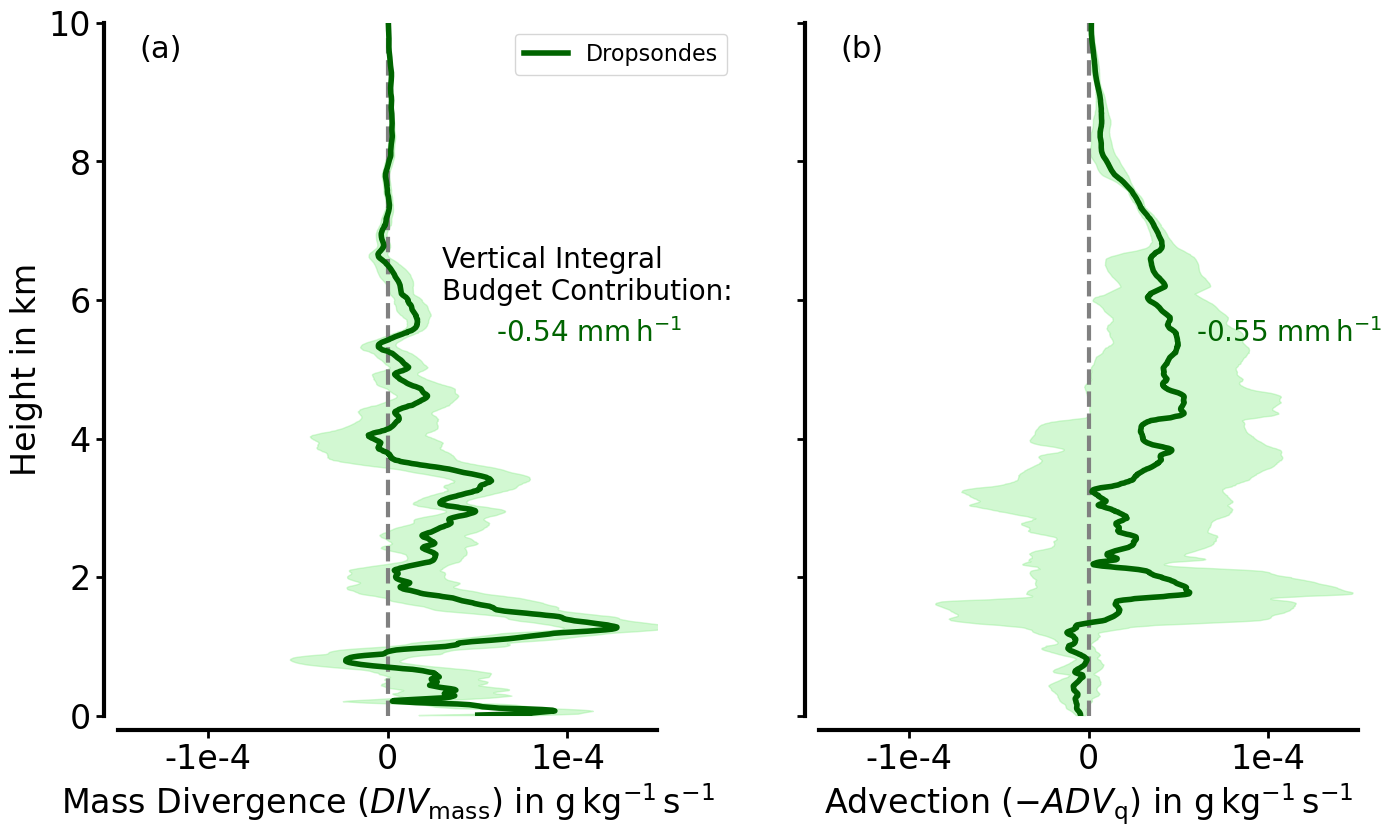

In [42]:
plot_sondes=True
if flight[0]=="RF05" and sector_to_plot=="cold":
    z_height_retrieval=pd.Series()
    plot_sondes=False
plot_haloac3_atmospheric_moist_trans_divergence(Moisture_CONV,ICON_Moisture_CONV,
                                                highres_ICON_Moisture_CONV,np.nan,np.nan,sector_to_plot,
                                                z_height,z_height_hr,np.nan,np.nan,plot_sondes=plot_sondes,
                                                plot_path=plot_path,do_plot_icon=False,do_plot_era5=False,
                                                scalar_based_div=scalar_based_div,
                                                save_for_manuscript=True)

In [43]:
ERA5_Moisture_CONV.integrated_divergence

{'ADV': AC3_RF05_sonde_100_ADV   -0.502094
 dtype: float64,
 'CONV': AC3_RF05_sonde_100_CONV   -0.540925
 dtype: float64}

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig14_RF05_AR_entire_2_warm_sonde_moist_transp_divergence.pdf


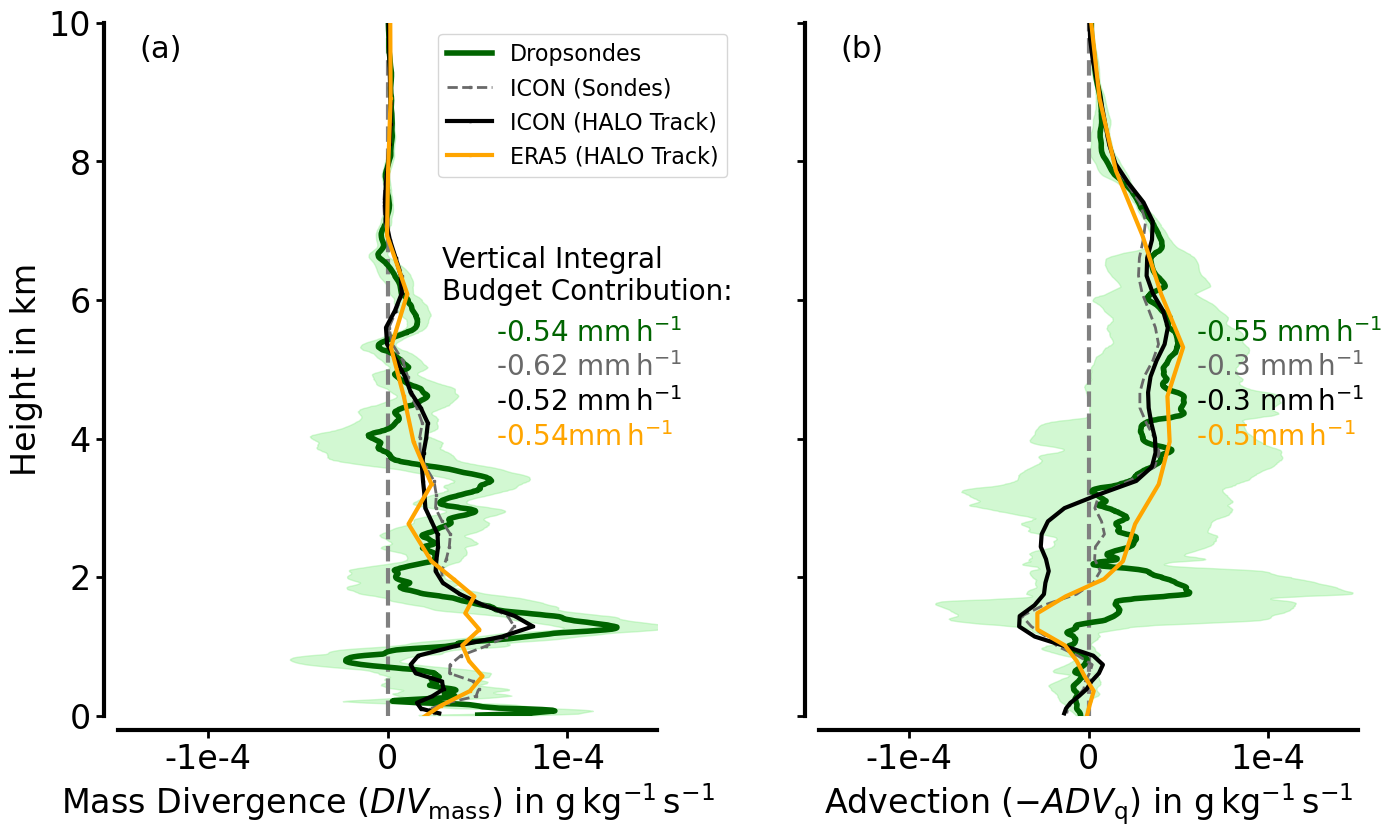

In [44]:
plot_haloac3_atmospheric_moist_trans_divergence(Moisture_CONV,ICON_Moisture_CONV,
                                                highres_ICON_Moisture_CONV,np.nan,ERA5_Moisture_CONV,sector_to_plot,
                                                z_height,z_height_hr,np.nan,z_height_era5,plot_sondes=plot_sondes,
                                                do_plot_icon=True,do_plot_era5=True,
                                               scalar_based_div=scalar_based_div)

### Uncertainty estimates using Gaussian rule for integral

In [45]:
## Min and Max statistics for tendency evolution
mass_div=Moisture_CONV.div_vector_mass[sector_to_plot]
adv_q=Moisture_CONV.adv_q_vector[sector_to_plot]


In [46]:
window_size=40
regridded_mass_div=mass_div.rolling(window_size).mean()[::(window_size-1)]
regridded_adv_q=adv_q.rolling(window_size).mean()[::(window_size-1)]
std_adv=regridded_adv_q.std()["unc"]
std_mass=regridded_mass_div.std()["unc"]
print(regridded_adv_q.index)
pres_index=Moisture_CONV.sector_sonde_values["warm"]["pres"].mean(axis=1)
pres_index=pres_index.loc[regridded_adv_q.index]#=pd.Series(p_grid*100)
pres_range=(pres_index.iloc[0]-pres_index.iloc[-1])*100
print(pres_range)
unc_adv=1/9.81*pres_range*std_adv/np.sqrt(regridded_adv_q.shape[0])*3.6/997*1000
unc_mass=1/9.81*pres_range*std_mass/np.sqrt(regridded_adv_q.shape[0])*3.6/997*1000
print("UNC adv",unc_adv)
print("UNC mass",unc_mass)

#regridded_pres_index=pres_index.rolling(19).mean()[::18]
#print(regridded_pres_index)
#print(flight[0],ar_of_day)
#plt.plot(regridded_pres_index,regridded_adv_q["unc"])
#plt.invert_yaxis()
#Moisture_CONV.integrated_divergence

Float64Index([   10.0,   510.0,   960.0,  1420.0,  1820.0,  2230.0,  2630.0,
               3020.0,  3420.0,  3830.0,  4260.0,  4750.0,  5310.0,  5930.0,
               6780.0,  7580.0,  8510.0,  9100.0,  9870.0, 10410.0],
             dtype='float64')
75247.998046875
UNC adv 0.1722415822353062
UNC mass 0.07579105179504261


In [47]:
# Second uncertainty test

In [48]:
std_adv

2.7811199404908535e-05

In [49]:
pres_range

75247.998046875

In [50]:
regridded_adv_q

,val,unc
10.0,NaN,NaN
510.0,-0.000007,9.377626e-06
960.0,-0.000005,1.037566e-05
1420.0,-0.000005,3.220460e-05
1820.0,0.000027,8.971666e-05
2230.0,0.000034,6.516276e-05
2630.0,0.000020,4.478463e-05
3020.0,0.000017,5.573004e-05
3420.0,0.000010,6.921298e-05
3830.0,0.000036,6.567611e-05


In [51]:
pres_index

10.0       990.990173
510.0      931.310547
960.0      880.504028
1420.0     831.047852
1820.0     790.088928
2230.0     750.022949
2630.0     712.548340
3020.0     677.732117
3420.0     643.304382
3830.0     609.827271
4260.0     576.231262
4750.0     539.936401
5310.0     500.836426
5930.0     460.276154
6780.0     409.143188
7580.0     365.214539
8510.0     318.966156
9100.0     292.032806
9870.0     259.540649
10410.0    238.510178
dtype: float32

In [52]:
#gaussian_advq=np.sqrt(np.sum(regridded_adv_q["unc"]**2))
quad=regridded_adv_q["unc"]**2
quad=quad.iloc[1::]
print(quad)
print(quad.shape[0])
print(pres_index.shape[0])
unc_adv_2=np.trapz(quad.values,x=pres_index.iloc[1::]**2)
unc_adv_2

510.0      8.793986e-11
960.0      1.076542e-10
1420.0     1.037136e-09
1820.0     8.049078e-09
2230.0     4.246185e-09
2630.0     2.005663e-09
3020.0     3.105837e-09
3420.0     4.790437e-09
3830.0     4.313352e-09
4260.0     3.525035e-09
4750.0     2.573080e-09
5310.0     1.701637e-09
5930.0     1.213218e-09
6780.0     5.969547e-10
7580.0     1.483596e-11
8510.0     3.647911e-11
9100.0     9.571442e-12
9870.0     2.736473e-12
10410.0    4.111474e-13
Name: unc, dtype: float64
19
20


-0.0018794623015211947

In [53]:
mean_pres_gradient=pres_index.diff().mean()
mean_pres_gradient

-39.604214

## Save divergence values in budget dataframe

In [54]:
div_values=pd.Series(Moisture_CONV.integrated_divergence["warm"])
div_values=div_values.rename({"mass_div":"DIV_mass","q_ADV":"ADV_q"},axis=0)
#div_values=pd.Series(Moisture_CONV.integrated_divergence
#div_values.append()
divergence_series=div_values.append(pd.Series(data=[unc_adv,unc_mass],index=["ADV_q_unc","DIV_mass_unc"]))
#divergence_series

In [55]:
import Airborne_Budget_Plots as Airplots

cmpgn_cls.plot_path=cmpgn_cls.campaign_data_path+"/plots/"
haloac3_budget_plots  = Airplots.HALO_AC3_Budget_Plots(cmpgn_cls,flight,ar_of_day)

#mean_div_values=warm_radar_internal_precip[["ADV","ADV_unc","DIV","DIV_unc"]].mean(axis=0)
#precip_rates=pd.Series(data=mean_radar_internal_precip.values,index=["ADV_q","ADV_q_unc","DIV_mass","DIV_mass_unc"])
haloac3_budget_plots.change_values_in_budget_df(divergence_series)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/
DIV_mass       -0.539671
ADV_q          -0.553945
ADV_q_unc       0.172242
DIV_mass_unc    0.075791
dtype: float64
      IWV_dt  IWV_dt_unc     ADV_q  ADV_q_unc  DIV_mass  DIV_mass_unc  \
S1 -0.767738    0.211316 -0.278493   0.139154 -0.497346      0.056066   
S2 -0.193738    0.238721 -0.553945   0.172242 -0.539671      0.075791   
S3  0.836216    0.165098  0.593545   0.140111  0.006555      0.094550   
S4  0.560422    0.090336  0.278702   0.380346  0.035408      0.105728   

      Precip  Precip_min  Precip_max      Evap  Evap_unc  
S1  0.057032    0.014287    0.123682  0.007065  0.059248  
S2  0.041188    0.007473    0.103877 -0.006380  0.062227  
S3  0.050191    0.013511    0.110727  0.056166  0.061512  
S4  0.003945    0.001085    0.010733  0.089814  0.052798  
budget df saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\

# Appendix (I) Instantaneous Analysis

### Instantaneous analysis

In [56]:
add_instantan=True
if add_instantan:
    inst_ERA5_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,grid_name="ERA5",
            sector_types=[sector_to_plot],do_instantan=add_instantan,calc_from_scalar_values=scalar_based_div)
    print("Instantaneous ERA5 moisture convergence class allocated")


Instantaneous ERA5 moisture convergence class allocated


In [57]:
# --> check that
date=flight_dates[flight[0]]
if add_instantan:
    inst_ERA5_on_HALO=Grid_on_HALO.ERA_on_HALO(halo_df,cmpgn_cls.campaign_path+"/data/ERA-5/",
        "hydrometeors_pressure_levels_"+date+".nc",flight[0]+"_"+ar_of_day+"_IWC_"+date+".csv",
        True,"HALO_AC3", config_file["Data_Paths"]["campaign_path"],flight,date,config_file,
        ar_of_day=ar_of_day,synthetic_flight=False,do_instantaneous=True)

    inst_era5_hmc=inst_ERA5_on_HALO.load_hwc()
    inst_HMC=inst_era5_hmc.copy()
    inst_HMC["q"]["old_index"]=halo_df.index
    #inst_HMC["q"]

Hydrometeor Content Profiles are already interpolated and saved
So load the data
IWC
LWC
PWC
Geopot_Z
q
theta_e
u
v


In [58]:
### Instantan sonde profiles

In [59]:
if add_instantan:
    inst_inflow_no        =   sondes_selection["inflow_warm_sector"]
    inst_outflow_no       =   sondes_selection["outflow_warm_sector"]
    inst_q_inflow_sondes  = inst_HMC["q"].iloc[inst_inflow_no]
    inst_q_outflow_sondes = inst_HMC["q"].iloc[inst_outflow_no]
    inst_u_inflow_sondes  = inst_HMC["u"].iloc[inst_inflow_no]
    inst_u_outflow_sondes = inst_HMC["u"].iloc[inst_outflow_no]
    inst_v_inflow_sondes  = inst_HMC["v"].iloc[inst_inflow_no]
    inst_v_outflow_sondes = inst_HMC["v"].iloc[inst_outflow_no]
    inst_z_inflow_sondes  = inst_HMC["Geopot_Z"].iloc[inst_inflow_no]
    inst_z_outflow_sondes = inst_HMC["Geopot_Z"].iloc[inst_outflow_no]
    
    # calculate additional parameters
    inst_wind_inflow_sondes      = np.sqrt(inst_u_inflow_sondes**2+\
                                       inst_v_inflow_sondes**2)
    inst_wind_outflow_sondes     = np.sqrt(inst_u_outflow_sondes**2+\
                                        inst_v_outflow_sondes**2)
    inst_moist_transport_inflow  = inst_q_inflow_sondes*inst_wind_inflow_sondes
    inst_moist_transport_outflow = inst_q_outflow_sondes*inst_wind_outflow_sondes

    ### Prepare the pattern for regression method
    inst_sondes_pos_all=inst_ERA5_Moisture_CONV.get_xy_coords_for_domain(
                        sondes_pos_all)
    ### remove doubled indicies and merge the sectors
    inst_domain_values={}
    inst_moist_transport_inflow=inst_moist_transport_inflow.groupby(level=0).last()
    inst_moist_transport_outflow=inst_moist_transport_outflow.groupby(level=0).last()
    inst_u_inflow_sondes=inst_u_inflow_sondes.groupby(level=0).last()
    inst_u_outflow_sondes=inst_u_outflow_sondes.groupby(level=0).last()
    inst_v_inflow_sondes=inst_v_inflow_sondes.groupby(level=0).last()
    inst_v_outflow_sondes=inst_v_outflow_sondes.groupby(level=0).last()
    inst_q_inflow_sondes=inst_q_inflow_sondes.groupby(level=0).last()
    inst_q_outflow_sondes=inst_q_outflow_sondes.groupby(level=0).last()
    inst_wind_inflow_sondes=inst_wind_inflow_sondes.groupby(level=0).last()
    inst_wind_outflow_sondes=inst_wind_outflow_sondes.groupby(level=0).last()
    inst_z_inflow_sondes=inst_z_inflow_sondes.groupby(level=0).last()
    inst_z_outflow_sondes=inst_z_outflow_sondes.groupby(level=0).last()

    inst_domain_values["transport"]=pd.concat([inst_moist_transport_inflow,
                                      inst_moist_transport_outflow])
    inst_domain_values["u"]=pd.concat([inst_u_inflow_sondes,
                                  inst_u_outflow_sondes])
    inst_domain_values["v"]=pd.concat([inst_v_inflow_sondes,
                                  inst_v_outflow_sondes])
    inst_domain_values["q"]=pd.concat([inst_q_inflow_sondes,
                                  inst_q_outflow_sondes])
    inst_domain_values["wind"]=pd.concat([inst_wind_inflow_sondes,
                              inst_wind_outflow_sondes])
    inst_domain_values["z"]=pd.concat([inst_z_inflow_sondes,
                                  inst_z_outflow_sondes])

    inst_mean_q,inst_dx_q_calc,inst_dy_q_calc = inst_ERA5_Moisture_CONV.run_regression(sondes_pos_all,inst_domain_values,"q")
    inst_mean_u,inst_dx_u,inst_dy_u           = inst_ERA5_Moisture_CONV.run_regression(sondes_pos_all,inst_domain_values,"u")
    inst_mean_v,inst_dx_v,inst_dy_v           = inst_ERA5_Moisture_CONV.run_regression(sondes_pos_all,inst_domain_values,"v")
    
    
    inst_div_mass=inst_domain_values["q"].mean(axis=0).values*1000*(inst_dx_u+inst_dy_v)
    inst_adv_q=(inst_domain_values["u"].mean(axis=0).values*inst_dx_q_calc+\
           inst_domain_values["v"].mean(axis=0).values*inst_dy_q_calc)*1000
    inst_ERA5_budget_regression_profile_df=pd.DataFrame(data=np.nan,
                index=inst_div_mass.index,
                columns=["CONV","ADV_calc"])
    inst_ERA5_budget_regression_profile_df["CONV"]=inst_div_mass.values
    inst_ERA5_budget_regression_profile_df["ADV_calc"]=inst_adv_q.values
    inst_z_height_era5=inst_domain_values["z"].mean(axis=0)
    inst_ERA5_budget_regression_profile_df["z"]=inst_z_height_era5.values
    inst_ERA5_Moisture_CONV.div_vector_mass=div_mass.copy()
    inst_ERA5_Moisture_CONV.adv_q_vector=adv_q.copy()
    save_budgets=True
    # Save budget values
    if save_budgets:
        name_arg=""
        file_end=".csv"
        inst_budget_file_name=flight[0]+"_instantan_AR_"+sector+"_"+\
            grid_name+"_regr_sonde_no_"+str(number_of_sondes)+\
                name_arg+"_vectorised"
        inst_budget_file_name+=file_end
        print(inst_budget_file_name)
        inst_ERA5_budget_regression_profile_df.to_csv(
        path_or_buf=budget_data_path+budget_file_name)    
        print("Convergence components saved as: ",budget_data_path+budget_file_name)
        sonde_pos_fname=flight[0]+"_instantan_Sonde_Location_"+sector+"_"+\
                grid_name+"_regr_sonde_no_"+str(number_of_sondes)
        sonde_pos_fname=sonde_pos_fname+".csv"
        sondes_pos_all.to_csv(path_or_buf=budget_data_path+\
                         sonde_pos_fname)
        print("Sonde position saved as:",budget_data_path+sonde_pos_fname)
####inst_dx_u

domain ready for regression
RF05_instantan_AR_warm_sector_ERA5_regr_sonde_no_100_vectorised.csv
Convergence components saved as:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF05_AR_warm_sector_ERA5_regr_sonde_no_100_vectorised.csv
Sonde position saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF05_instantan_Sonde_Location_warm_sector_ERA5_regr_sonde_no_100.csv


#### Instantaneous budget integrals

In [60]:
inst_pres_index=pd.Series(inst_ERA5_budget_regression_profile_df.index*100)
g=9.82
inst_warm_budgets={}
inst_warm_budgets["ADV"]  = pd.Series()
inst_warm_budgets["CONV"] = pd.Series()
campaign_id="AC3_"
for term in ["ADV","CONV"]:
    if term=="ADV":
        series_term=term+"_calc"
    else:
        series_term=term
    inst_warm_budgets[term].at[campaign_id+flight[0]+"_sonde_100_"+term]=\
                    -1/(997*g)*np.trapz(inst_ERA5_budget_regression_profile_df[series_term]/1000,
                                 axis=0,x=inst_pres_index)*3600*1000
inst_warm_budgets

{'ADV': AC3_RF05_sonde_100_ADV    0.800717
 dtype: float64,
 'CONV': AC3_RF05_sonde_100_CONV   -1.078013
 dtype: float64}

In [61]:
## Plot moisture budget terms

figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/HALO_AC3_RF05_AR_entire_2_divIVT_instantan_comparison.pdf


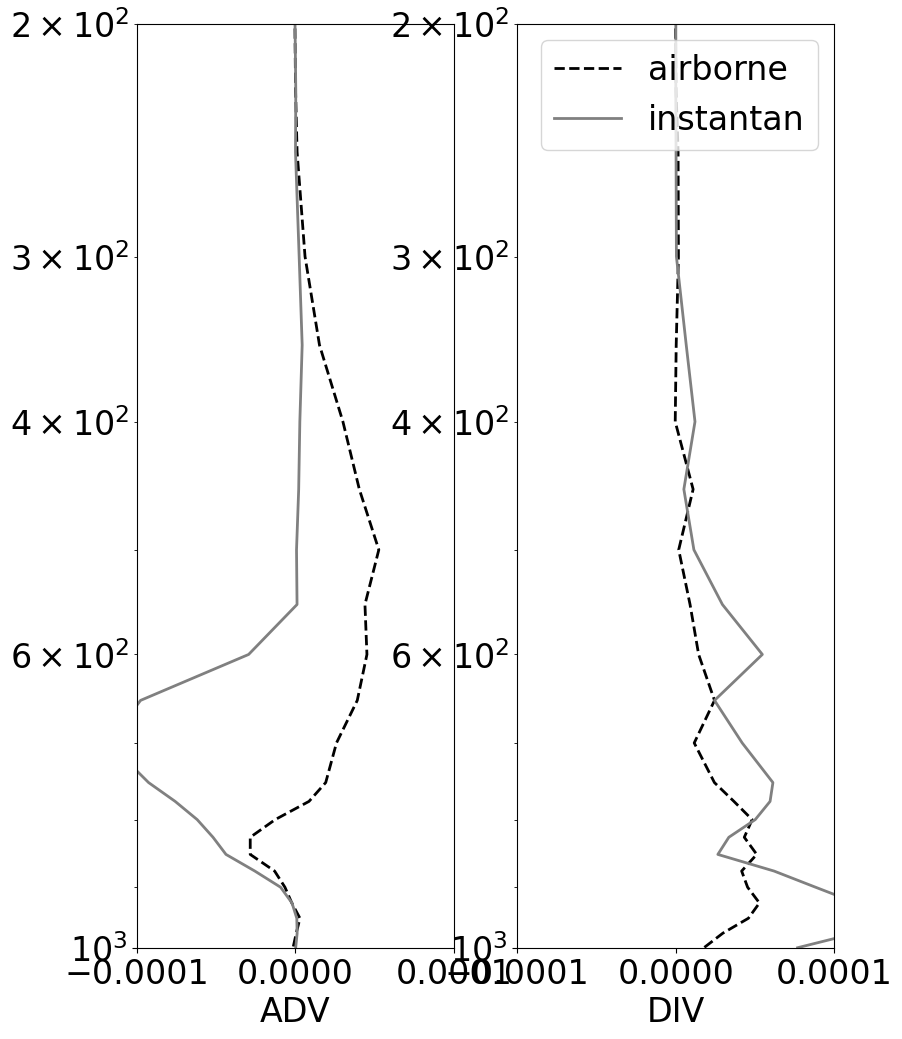

In [62]:
inst_budget_fig=plt.figure(figsize=(9,12))
ax1=inst_budget_fig.add_subplot(121)
ax2=inst_budget_fig.add_subplot(122)
ax1.plot(ERA5_budget_regression_profile_df["ADV_calc"].values,ERA5_budget_regression_profile_df.index,lw=2,ls="--",color="black")
ax1.plot(inst_ERA5_budget_regression_profile_df["ADV_calc"].values,inst_ERA5_budget_regression_profile_df.index,
        lw=2,ls="-",color="grey")
ax2.plot(ERA5_budget_regression_profile_df["CONV"].values,ERA5_budget_regression_profile_df.index,
         ls="--",lw=2,color="black",label="airborne")
ax2.plot(inst_ERA5_budget_regression_profile_df["CONV"].values,inst_ERA5_budget_regression_profile_df.index,
        lw=2,color="grey",label="instantan")
#ax1.axhline(0,ymin=50,ymax=1100,ls="--",lw=2,color="grey")
ax1.set_ylim([200,1000])
ax1.set_xlim([-1e-4,1e-4])
ax2.set_ylim([200,1000])
ax2.set_xlim([-1e-4,1e-4])

ax1.invert_yaxis()
ax2.invert_yaxis()
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlabel("ADV")
ax2.set_xlabel("DIV")
ax2.legend()
fig_name="HALO_AC3_"+flight[0]+"_"+ar_of_day+"_divIVT_instantan_comparison.pdf"
inst_budget_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("figure saved as:",plot_path+fig_name)

# Appendix (II) Retrieval

In [63]:
def get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000):
    idx_height=np.argmin(abs(np.array(retrieval_coeff_heights)-halo_height))
    relevant_height=retrieval_coeff_heights[idx_height]
    return idx_height,relevant_height

def open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"):
    height=act_halo_height.copy()
    idx_height,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=height)
    m_est_height=pd.read_csv(coeff_path+var_to_retrieve+"_Retrieval_coeffs_several_dates_"+str(relevant_height)+".csv",
                            index_col="Unnamed: 0")
    return m_est_height

## Radiometer dataset

In [64]:
if include_hamp_retrieval:
    # processing_path packages
    import data_config
    import measurement_instruments_ql
    import campaign_netcdf
    import halodataplot as Data_Plotter
    import quicklook_dicts
    radar_dict={}
    bahamas_dict={}  
    campaign=cmpgn_cls.name
    airborne_data_importer_path=major_work_path+\
                                    "hamp_processing_py/"+\
                                        "hamp_processing_python/Flight_Data/"+campaign+"/"
    date=flight_dates[flight[0]]
    ###############################################################################
    inflow=False
    # Radar reflectivity
    cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
    cfg_dict["device_data_path"]=airborne_data_importer_path
    with HiddenPrints():
        # Data Handling 
        datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
        # Get Plotting Handling
        plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                                quicklook_dicts.get_plotting_handling_attrs_dict()

    HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
    HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
    Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
    Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)
    Radiometer_cls=measurement_instruments_ql.HAMP(HALO_Devices_cls)
    import halodataplot as halo_data_plotter

    Quick_Plotter=Data_Plotter.Quicklook_Plotter(cfg_dict)
    Radiometer_Quicklook=halo_data_plotter.Radiometer_Quicklook(cfg_dict)
    calibrated_hamp=False
    Radiometer_cls.open_processed_hamp_data(open_calibrated=calibrated_hamp,
                                newest_version=True)
    if not calibrated_hamp:
        mwr=Radiometer_cls.processed_hamp_ds
    else:
        mwr=Radiometer_cls.calib_processed_hamp_ds
    if pd.Timestamp(inflow_times[0])<pd.Timestamp(outflow_times[-1]):
        mwr_cutted=mwr.sel({"time":slice(inflow_times[0],outflow_times[-1])})
    else:
        mwr_cutted=mwr.sel({"time":slice(outflow_times[0],inflow_times[-1])})
    Radiometer_Quicklook.radiometer_tb_dict=mwr_cutted
    Radiometer_Quicklook.cfg_dict["Flight_Dates_used"]
    #Radiometer_Quicklook.plot_radiometer_TBs(flight[0],raw_measurements=False)

## Retrieval Sondes HMC 

In [65]:
#------------------------------------------------------------------------------------------------------------#
# Retrieval
def retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height,
                    retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                        "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                        "Flight_Data\\HALO_AC3\\retrieval\\"):
    
    import glob
    retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    
    t_range=TB_K_reg_smoothed.shape[0]
    for t in range(t_range):#:
        rel_TB_K_reg=TB_K_reg_smoothed[t,:]
        act_halo_height=halo_height.iloc[t]
        # add height depedent retrieval applier
        m_est_heights=open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path=retrieval_coeff_path)
        if t==0:
            var_retrieved=pd.DataFrame(data=np.nan, columns=m_est_heights.index,index=brightness_Ts.index)

        if not (flight[0]=="RF06" and ar_of_day=="AR_entire_1"):
            for z in range(m_est_heights.shape[0]):
                var_retrieved.iloc[t,z]=m_est_heights.iloc[z,:].dot(Smoothed_Q_Retrieval.K_reg[t,:].T)
        performance.updt(t_range,t)
    if var_to_retrieve=="log_q":
        var_retrieved=np.exp(var_retrieved)
    return var_retrieved
#------------------------------------------------------------------------------------------------------------#
if include_hamp_retrieval:
    # Predefinitions
    import matplotlib.pyplot as plt
    import retrieval
    import PAMTRA_sim_analysis

    # Predefinitions
    coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\PhD_UHH_WIMI\\Work\\GIT_Repository"+\
                "\\hamp_processing_py\\hamp_processing_python\\Flight_Data\\HALO_AC3\\retrieval\\"
    var_to_retrieve="q"
    order=2
    # get MWR heights to choose relevant retrieval coefficients
    halo_height=pd.Series(data=mwr["alt"].values,index=pd.DatetimeIndex(mwr["alt"].time[:]))
    # # get all relevant retrieval heights
    import glob
    retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    # Process brightness temperatures
    brightness_Ts=pd.DataFrame(data=np.array(mwr["TB"][:]),
                           index=pd.DatetimeIndex(np.array(mwr.time[:])),
                           columns=np.array(mwr.freq[:]))
    brightness_Ts=brightness_Ts.sort_index(axis=1)
    # The retrieved hamp Q profiles for divergence calculations will rely on smoothened TBs
    smoothed_brightness_Ts=brightness_Ts.rolling("10s",min_periods=8).mean()
    # Initialize Retrieval class, most attributes are unused
    regr_retrieval=retrieval.Regression_Retrieval
    Smoothed_Q_Retrieval=regr_retrieval(xr.Dataset(),"q",smoothed_brightness_Ts,order,[date],os.getcwd(),
                      added_noise=True)
    Smoothed_Q_Retrieval.y=smoothed_brightness_Ts
    Smoothed_Q_Retrieval.build_K_reg()
    TB_K_reg_smoothed=Smoothed_Q_Retrieval.K_reg
    
    
    # block below
    retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                       "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                       "Flight_Data\\HALO_AC3\\retrieval\\"
    # Sonde retrieval
    retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_"+var_to_retrieve+".csv"

    recalculate_anyhow=False
    # check if file already exists
    if os.path.exists(retrieved_var_file_name):
        if not recalculate_anyhow:
            var_retrieved=pd.read_csv(retrieved_var_file_name,index_col=0)
            var_retrieved.index=pd.DatetimeIndex(var_retrieved.index)
            var_retrieved.columns=var_retrieved.columns.astype(float)
            #var_retrieved.to_csv(retrieved_var_file_name)
            print("Retrieved var saved as:",retrieved_var_file_name)
        else:
            var_retrieved=retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height)
            retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_"+var_to_retrieve+".csv"

    else:
        var_retrieved=retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height)       
        var_retrieved.to_csv(retrieved_var_file_name)
        print("Retrieved var saved as:",retrieved_var_file_name)

    print("Retrieved Variable saved as:",retrieved_var_file_name)
    var_retrieved_at_sonde=var_retrieved.loc[sonde_sector_times]
    var_retrieved.max(axis=1).plot()
    plt.ylim([0,0.008])
    for sonde in var_retrieved_at_sonde.index:
        var_retrieved_at_sonde[var_retrieved_at_sonde<0.0]=0.0
    plot_path=start_path+"/../plots/"
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"Quicklook_retrieval_hamp_sondes.png"
    plt.savefig(plot_path+fig_name)
    print("Figure saved as:",plot_path+fig_name)

In [66]:
if include_hamp_retrieval:
    plot_q_retrieval(flight,ar_of_day,var_to_retrieve,var_retrieved)

In [67]:
if include_hamp_retrieval:
    import scipy.interpolate as scint
    # create retrieval divergence calculations with new Moisture Budget class
    # it includes the retrieved q and then, from the sondes, p, u, v and calculates transport.
    # check for corresponding index of sondes and retrieval
    # each sonde has another height. Does it still work?
    Retrieval_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,
                     grid_name="Retrieval_Sondes",sector_types=[sector_to_plot],do_instantan=False)
    correct_sector=True
    if flight[0]=="RF06":
        correct_sector=False
    if correct_sector:        
        sonde_retrieval_hmc={}
        unified_heights=var_retrieved_at_sonde.columns
        for key in halo_icon_hmc.keys():
            if key=="IVT":
                continue
            if key=="q":
                sonde_retrieval_hmc[key]=var_retrieved_at_sonde
            else:
                sonde_retrieval_hmc[key]=halo_icon_hmc[key].loc[sonde_sector_times]

                var_df=pd.DataFrame(data=np.nan,columns=unified_heights,index=sonde_sector_times)
                for sonde in sonde_sector_times:
                    profile=halo_icon_hmc[key].loc[sonde,:].values
                    height_levels=halo_icon_hmc["Z_Height"].loc[sonde_sector_times].mean(axis=0).values
                    var_series=pd.Series(data=profile,
                                index=height_levels)
                    ## Interpolation function
                    var_fct = scint.interp1d(var_series.index, var_series,fill_value="extrapolate")
                    ## Get interpolated data
                    var_series_interp=pd.Series(var_fct(unified_heights),
                                        index=unified_heights)
                    var_df.loc[sonde]=var_series_interp
                sonde_retrieval_hmc[key]=var_df#return var_series_interp
                print(key," Sonde retrieval hmc shape:",sonde_retrieval_hmc[key].shape)

        sonde_retrieval_hmc["wind"]=np.sqrt(sonde_retrieval_hmc["u"]**2+sonde_retrieval_hmc["v"]**2)
        sonde_retrieval_hmc["transport"]=sonde_retrieval_hmc["wind"]*sonde_retrieval_hmc["q"]
    else:
        print("No Retrieval at sonde locations considered, as not applicable to HAMP data")

## Apply Q Regression Retrieval

### Perform retrieval-based sonde regression

In [68]:
if include_hamp_retrieval:
    if correct_sector:
        # Allocate Sondes Position all for ICON Moisture CONV, no rerun is needed
        Retrieval_Moisture_CONV.sondes_pos_all=Moisture_CONV.sondes_pos_all
        sector_div_vars={}
        uninterp_vars={}
        interp_vars={}
        # Run divergence calculations via regression for transport, q and wind
        sector_retrieval_mean_qv,sector_retrieval_dx_qv,sector_retrieval_dy_qv=\
            Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                                Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                sonde_retrieval_hmc,"transport")

        sector_retrieval_mean_q,sector_retrieval_dx_q_calc,sector_retrieval_dy_q_calc=\
            Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                                Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                sonde_retrieval_hmc,"q")
        sector_retrieval_mean_scalar_wind,sector_retrieval_dx_scalar_wind,sector_retrieval_dy_scalar_wind=\
            Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                                Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                    sonde_retrieval_hmc,
                                                    "wind")
        # Post calculations
        sector_retrieval_div_qv=(sector_retrieval_dx_qv+sector_retrieval_dy_qv)*1000
        sector_retrieval_div_scalar_wind = (sector_retrieval_dx_scalar_wind+sector_retrieval_dy_scalar_wind)
        sector_retrieval_div_q_calc      = (sector_retrieval_dx_q_calc+sector_retrieval_dy_q_calc)

        intersect_retrieval_index=sector_retrieval_div_qv.index.intersection(sector_retrieval_div_scalar_wind.index)
        intersect_retrieval_index=intersect_retrieval_index.intersection(sector_retrieval_div_q_calc.index)
        sector_retrieval_div_scalar_mass=sector_retrieval_div_scalar_wind.loc[intersect_retrieval_index]*\
                    sonde_retrieval_hmc["q"].loc[:,intersect_retrieval_index].mean(axis=0).values*1000
        sector_retrieval_adv_q_calc=sector_retrieval_div_q_calc.loc[intersect_retrieval_index]*\
                sonde_retrieval_hmc["wind"].loc[:,intersect_retrieval_index].mean(axis=0).values*1000##
        Retrieval_Moisture_CONV.div_scalar_mass={}
        Retrieval_Moisture_CONV.adv_q_calc={}
        Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot] = sector_retrieval_div_scalar_mass
        Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot]      = sector_retrieval_adv_q_calc
        z_height_retrieval_all=sonde_retrieval_hmc["Z_Height"].iloc[:,:].mean(axis=0)
        z_height_retrieval=z_height_retrieval_all.loc[intersect_retrieval_index]
    else:
        z_height_retrieval=np.nan


### Retrieval Moisture CONV vertically integrated divergence

In [69]:
if include_hamp_retrieval:
    if correct_sector:
        retr_integrated_divergence={}
        retr_p_grid=sonde_retrieval_hmc["p"].mean(axis=0)
        retr_pres_index=pd.Series(retr_p_grid)

        Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].index=retr_pres_index.dropna()
        Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].index=retr_pres_index.dropna()

        retr_integrated_divergence[sector_to_plot]={}
        retr_integrated_divergence[sector_to_plot]["mass_div"]= 1/(g*997)*np.trapz(
            Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].values*\
            Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].index)/1000*3600
        retr_integrated_divergence[sector_to_plot]["q_ADV"]= 1/(g*997)*np.trapz(
            Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].values*\
            Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].index)/1000*3600

        ###################################################################
        ### Default to use 
        #retr_integrated_divergence[sector_to_plot]={}
        #retr_integrated_divergence[sector_to_plot]["mass_div"]= 1/(997)*np.trapz(
        #    Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].values*retr_pres_index.dropna()[::-1])/1000*3600
        #retr_integrated_divergence[sector_to_plot]["q_ADV"]=1/(997)*np.trapz(\
        #    Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].values*retr_pres_index.dropna()[::-1])/1000*3600
        ###################################################################    
        Retrieval_Moisture_CONV.integrated_divergence=retr_integrated_divergence
        #retr_integrated_divergence

    Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"]=\
        np.sqrt(Moisture_CONV.sector_sonde_values[sector_to_plot]["u"]**2+\
                Moisture_CONV.sector_sonde_values[sector_to_plot]["v"]**2)

In [70]:
# List of uncertainties
#---------------------------------
#S1
# UNC adv  0.09904659648151819
# UNC mass 0.0390540623580486
#---------------------------------
#S2
# UNC adv  0.12255051592378231
# UNC mass 0.05330051908475317
#---------------------------------
#S3
# UNC adv  0.1029587189598431
# UNC mass 0.06758506711408048
#---------------------------------
#S4
#UNC adv 0.2973193759560851
#UNC mass 0.08439010200621463